In [2]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_path = './open'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

In [5]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [6]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

In [7]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7661, 1380, 10)
train_y_array (7661, 120, 10)
test_x_array (535, 1380, 10)



In [8]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

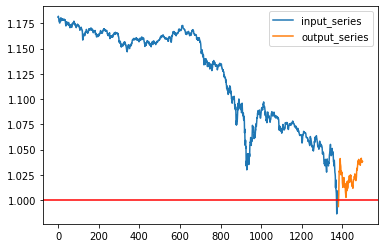

In [11]:
# sample_id 1012에 해당하는 sample의 분단위 시가 변동 정보 시각화
idx = 1012
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1])
plt.show()

In [13]:
!pip install statsmodels

You should consider upgrading via the 'c:\users\soyeon\python2021\scripts\python.exe -m pip install --upgrade pip' command.


In [14]:
from statsmodels.tsa.arima.model import ARIMA

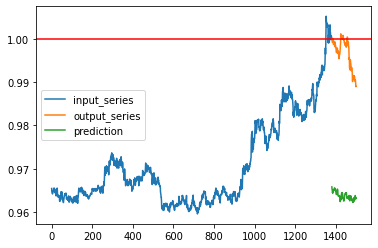

In [16]:
idx = 1121
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

# ARIMA의 (p,d,q) 값은 최적화 되지않은 값 입니다.
model = ARIMA(x_series, order=(3,0,1)) 
fit  = model.fit()
preds = fit.predict(1,120, typ='levels')

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds, label = 'prediction')
plt.legend()
plt.show()

In [17]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([300, 120])

In [18]:
# ARIMA의 (p,d,q) 값이 (5,1,1)에서 수렴하지 않을 경우
# (4,1,1)로 변경하여 다시 학습 및 추론
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        try:
            x_series = valid_x_array[idx,:,1]

            model = ARIMA(x_series, order=(5,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds# - (preds[0]-x_series[-1])
        except:
            print("order 4 1 1")
            x_series = valid_x_array[idx,:,1]

            model = ARIMA(x_series, order=(4,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            valid_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        # ARIMA의 (p,d,q) 값이 (5,1,1), (4,1,1)에서 수렴하지 않을 경우
        # 모두 0으로 채움
        pass

  2%|█▎                                                                                | 5/300 [00:06<05:34,  1.13s/it]c:\users\soyeon\python2021\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|█▉                                                                                | 7/300 [00:08<05:45,  1.18s/it]c:\users\soyeon\python2021\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|██▋                                                                              | 10/300 [00:13<05:51,  1.21s/it]c:\users\soyeon\python2021\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

In [19]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.15) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [20]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [21]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,112
1,1,0,118
2,2,1,86
3,3,0,113
4,4,0,0
...,...,...,...
295,295,0,99
296,296,0,109
297,297,1,36
298,298,0,25


In [22]:
valid_submission.buy_quantity.value_counts()

0    289
1     11
Name: buy_quantity, dtype: int64

In [23]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [24]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

In [25]:
print(total_momey)

10048.003921284504


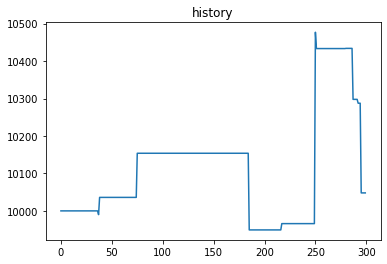

In [26]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

In [27]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        try:
            x_series = test_x_array[idx,:,1]

            model = ARIMA(x_series, order=(5,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            test_pred_array[idx,:] = preds
        except:
            x_series = test_x_array[idx,:,1]
            model = ARIMA(x_series, order=(4,1,1))
            fit  = model.fit()
            preds = fit.predict(1,120, typ='levels')
            test_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

  1%|▍                                                                                 | 3/535 [00:03<12:28,  1.41s/it]c:\users\soyeon\python2021\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|█▋                                                                               | 11/535 [00:12<08:46,  1.01s/it]c:\users\soyeon\python2021\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|██                                                                               | 14/535 [00:16<10:27,  1.20s/it]c:\users\soyeon\python2021\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximu

In [28]:
submission = array_to_submission(test_x_array, test_pred_array)

In [29]:
# 시즌 2 부터는 test_x_df의 sample_id가 train_x_df의 sample_id보다 큰 값을 갖습니다.
# 다음의 코드를 추가하여 submission의 sample_id 값을 적절히 지정해야 합니다.
submission.sample_id = submission.sample_id + test_x_df.sample_id.min()

In [30]:
submission.to_csv("baseline_submission.csv", index = False)